# **PPO agent Implementation**

Here we gonna implement the PPO method to be able to compare if the agent is able to learn faster.

In [ ]:
# # If on colab
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install gym-super-mario-bros==7.4.0
!pip install tensordict==0.3.0
!pip install torchrl==0.3.0
!pip install nes-py

# **Imports all needed libs**

In [1]:
import torch
from torch import nn
from torchvision import transforms as T
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from tqdm import tqdm

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from gym.wrappers.monitoring import video_recorder

from stable_baselines3 import PPO

# **Init and test of the env**

In [2]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
print(gym.__version__)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

0.26.2


d:\anaconda\envs\Mario-RL\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
d:\anaconda\envs\Mario-RL\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


d:\anaconda\envs\Mario-RL\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# **Preprocess of the env**

In [3]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info

class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

-----------------------------------------------

**<h1><center>Definition of the different agents</center></h1>**

# **PPO: Proximal Policy Optimization**

### **Definition of PPO with Mlp policy**

In [4]:
class ActorCritic_Mlp(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic_Mlp, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(np.prod(state_dim), 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(np.prod(state_dim), 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    
    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value

class PPO_Mlp:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        flattened_state_dim = np.prod(state_dim)  # Calculate the flattened state dimension
        self.model = ActorCritic_Mlp(flattened_state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam([
            {'params': self.model.actor.parameters(), 'lr': lr_actor},
            {'params': self.model.critic.parameters(), 'lr': lr_critic}
        ])
        self.gamma = gamma
        self.K_epochs = K_epochs
        self.eps_clip = eps_clip
        self.memory = []
        self.batch_size = 64
   
    def select_action(self, state):
        state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
        state = torch.FloatTensor(state).flatten().unsqueeze(0).to(self.device)  # Flatten the state
        action_probs, _ = self.model(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item()
   
    def update(self, memory):
        states, actions, rewards, next_states, dones = zip(*self.memory)
        states = np.array([state[0].__array__() if isinstance(state, tuple) else state.__array__() for state in states])
        states = torch.FloatTensor(states).flatten(1).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = np.array([state[0].__array__() if isinstance(state, tuple) else state.__array__() for state in next_states])
        next_states = torch.FloatTensor(next_states).flatten(1).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
       
        for _ in range(self.K_epochs):
            action_probs, values = self.model(states)
            dist = Categorical(action_probs)
            action_log_probs = dist.log_prob(actions)
           
            _, next_values = self.model(next_states)
            returns = self.compute_returns(rewards, next_values, dones)
           
            advantages = returns - values
           
            ratio = torch.exp(action_log_probs - action_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
           
            critic_loss = 0.5 * (returns - values).pow(2).mean()
           
            self.optimizer.zero_grad()
            (actor_loss + critic_loss).backward()
            self.optimizer.step()
   
    def compute_returns(self, rewards, next_values, dones):
        returns = torch.zeros_like(rewards)
        running_return = next_values[-1]
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + self.gamma * running_return * (1 - dones[t])
            returns[t] = running_return
        return returns
    
    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))

### **Definition of PPO with Cnn policy**

In [5]:
class ActorCritic_Cnn(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic_Cnn, self).__init__()
        self.conv1 = nn.Conv2d(state_dim[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        conv_output_size = self._get_conv_output(state_dim)
        
        self.actor = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def _get_conv_output(self, shape):
        x = torch.zeros(1, *shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(np.prod(x.size()))
    
    def forward(self, state):
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        
        action_probs = self.actor(x)
        value = self.critic(x)
        return action_probs, value

class PPO_Cnn:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = ActorCritic_Cnn(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam([
            {'params': self.model.actor.parameters(), 'lr': lr_actor},
            {'params': self.model.critic.parameters(), 'lr': lr_critic}
        ])
        self.gamma = gamma
        self.K_epochs = K_epochs
        self.eps_clip = eps_clip
        self.memory = []
        self.batch_size = 64
    
    def select_action(self, state):
        state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action_probs, _ = self.model(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item()
    
    def update(self, memory):
        states, actions, rewards, next_states, dones = zip(*self.memory)
        states = np.array([state[0].__array__() if isinstance(state, tuple) else state.__array__() for state in states])
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = np.array([state[0].__array__() if isinstance(state, tuple) else state.__array__() for state in next_states])
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        for _ in range(self.K_epochs):
            action_probs, values = self.model(states)
            dist = Categorical(action_probs)
            action_log_probs = dist.log_prob(actions)
            
            _, next_values = self.model(next_states)
            returns = self.compute_returns(rewards, next_values, dones)
            
            advantages = returns - values
            
            ratio = torch.exp(action_log_probs - action_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            critic_loss = 0.5 * (returns - values).pow(2).mean()
            
            self.optimizer.zero_grad()
            (actor_loss + critic_loss).backward()
            self.optimizer.step()
    
    def compute_returns(self, rewards, next_values, dones):
        returns = torch.zeros_like(rewards)
        running_return = next_values[-1]
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + self.gamma * running_return * (1 - dones[t])
            returns[t] = running_return
        return returns
    
    def save(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        self.model.load_state_dict(torch.load(path))

# **DQN: Deep Q Network - DDQN: Double Deep Q Network**

### **Definition of the DQN**

In [6]:
# TODO

### **Definition of the DDQN**

In [7]:
class MarioNet(nn.Module):
    """mini CNN structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

class DDQN:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net = MarioNet(self.state_dim, self.action_dim).float().to(device=self.device)
        
        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0
        self.save_every = 5e5
        
        self.memory = []
        self.batch_size = 32
        self.gamma = 0.9
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()
        
        self.burnin = 1e4
        self.learn_every = 3
        self.sync_every = 1e4

    def select_action(self, state):
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        self.curr_step += 1
        return action_idx

    def recall(self):
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    def update(self, memory):
        states, actions, rewards, next_states, dones = zip(*self.memory)
        states = np.array([state[0].__array__() if isinstance(state, tuple) else state.__array__() for state in states])
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = np.array([state[0].__array__() if isinstance(state, tuple) else state.__array__() for state in next_states])
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        td_est = self.td_estimate(states, actions)
        # Get TD Target
        td_tgt = self.td_target(rewards, next_states, dones)
        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

    def save(self, path):
        torch.save(self.net.state_dict(), path)

    def load(self, path):
        self.net.load_state_dict(torch.load(path))

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[np.arange(0, self.batch_size), action]
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[np.arange(0, self.batch_size), best_action]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()
    
    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

---------------------------------------------------

**<h1><center>Definition of the training and testing process</center></h1>**

*Saving process:*

*1- Save the model based on the average reward over a certain number of episodes instead of relying on a single episode's reward. This helps smooth out the variability and provides a more reliable measure of the agent's performance.*

In [8]:
def train(env, agent, num_episodes, max_steps, save_path, save_interval=10):
    info_list = []
    best_mean_reward = -np.inf
    with tqdm(total=num_episodes, desc="Training", unit="episode") as pbar:
        for episode in range(num_episodes):
            state = env.reset()
            episode_reward = 0
            
            for step in range(max_steps):
                action = agent.select_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                
                episode_reward += reward
                
                agent.memory.append((state, action, reward, next_state, done))
                
                if len(agent.memory) >= agent.batch_size:
                    agent.update(agent.memory)
                    agent.memory = []
                
                state = next_state
                
                if done:
                    break
            
            info_list.append([episode, episode_reward, step])

            if episode % save_interval == 0 and episode > 0:
                mean_reward = np.mean([info[1] for info in info_list[-save_interval:]])
                if mean_reward > best_mean_reward:
                    best_mean_reward = mean_reward
                    agent.save(save_path)
            
            pbar.set_description(f"Episode {episode+1} - Last Reward: {episode_reward:.2f}")
            pbar.update(1)
    
    return info_list

In [9]:
def test_visualized(agent):
   if gym.__version__ < '0.26':
      env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
   else:
      env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='human', apply_api_compatibility=True)
   
   env = JoypadSpace(env, [["right"], ["right", "A"]])

   env = SkipFrame(env, skip=4)
   env = GrayScaleObservation(env)
   env = ResizeObservation(env, shape=84)
   if gym.__version__ < '0.26':
      env = FrameStack(env, num_stack=4, new_step_api=True)
   else:
      env = FrameStack(env, num_stack=4)
   
   state = env.reset()
   done = False

   while done == False:
      action = agent.select_action(state)
      state, reward, done, truncated, info = env.step(action)
      env.render()
      
   env.close()

------------------------------------------------------------------------

**<h1><center>Training and log process</center></h1>**

In [10]:
state_dim = env.observation_space.shape
action_dim = env.action_space.n

In [11]:
print("state_dim = ", state_dim)
print("action_dim = ", action_dim)

state_dim =  (4, 84, 84)
action_dim =  2


### **Training of DQN**

In [12]:
# TODO

### **Training of DDQN**

In [20]:
ddqn_agent = DDQN(state_dim=(4, 84, 84), action_dim=env.action_space.n)

In [21]:
# Train the agent
num_episodes = 10
max_steps = 2000
save_path = "../best_agent/best_agent_ddqn.pth"

info_list_ddqn = train(env, ddqn_agent, num_episodes, max_steps, save_path)

Episode 10 - Last Reward: 599.00: 100%|██████████| 10/10 [00:23<00:00,  2.35s/episode]


In [22]:
info_list_ddqn_df = pd.DataFrame(info_list_ddqn)
info_list_ddqn_df.to_csv('../logs/info_list_ddqn.csv', index=False)  

### **Train PPO with MLP policy**

In [23]:
# Create the PPO agent for mlp
ppo_mlp_agent = PPO_Mlp(state_dim, action_dim, lr_actor=0.0003, lr_critic=0.0003, gamma=0.99, K_epochs=10, eps_clip=0.2)

In [24]:
# Train the agent
num_episodes = 10
max_steps = 2000
save_path = "../best_agent/best_agent_ppo_mlp.pth"

info_list_mlp = train(env, ppo_mlp_agent, num_episodes, max_steps, save_path)

Episode 10 - Last Reward: 678.00: 100%|██████████| 10/10 [00:35<00:00,  3.56s/episode]


In [25]:
info_list_mlp_df = pd.DataFrame(info_list_mlp)
info_list_mlp_df.to_csv('../logs/info_list_mlp.csv', index=False)  

### **Train PPO with CNN policy**

In [26]:
# Create the PPO agent for cnn
ppo_cnn_agent = PPO_Cnn(state_dim, action_dim, lr_actor=0.0003, lr_critic=0.0003, gamma=0.99, K_epochs=10, eps_clip=0.2)

In [27]:
# Train the agent
num_episodes = 10
max_steps = 2000
save_path = "../best_agent/best_agent_ppo_cnn.pth"

info_list_cnn = train(env, ppo_cnn_agent, num_episodes, max_steps, save_path)

Episode 10 - Last Reward: 1041.00: 100%|██████████| 10/10 [00:36<00:00,  3.62s/episode]


In [28]:
info_list_cnn_df = pd.DataFrame(info_list_cnn)
info_list_cnn_df.to_csv('../logs/info_list_cnn.csv', index=False)

------------------------------------------------------

**<h1><center>Plot results</center></h1>**

In [35]:
#df_dqn
df_ddqn = pd.read_csv("../logs/info_list_ddqn.csv", names=["Episode", "Reward", "Steps"])
df_ppo_mlp = pd.read_csv("../logs/info_list_mlp.csv", names=["Episode", "Reward", "Steps"])
df_ppo_cnn = pd.read_csv("../logs/info_list_cnn.csv", names=["Episode", "Reward", "Steps"])

In [36]:
print(df_ddqn.head())

   Episode  Reward  Steps
0        0     1.0      2
1        0  1165.0    941
2        1   589.0    113
3        2   620.0    100
4        3   699.0    198


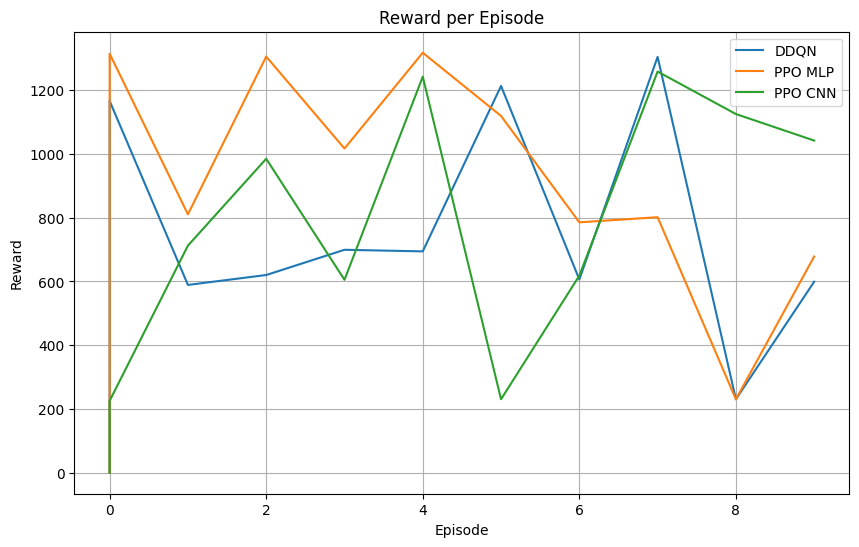

In [37]:
# Plotting
plt.figure(figsize=(10, 6))

#plt.plot(df_dqn["Episode"], df_dqn["Reward"], label="DQN")
plt.plot(df_ddqn["Episode"], df_ddqn["Reward"], label="DDQN")
plt.plot(df_ppo_mlp["Episode"], df_ppo_mlp["Reward"], label="PPO MLP")
plt.plot(df_ppo_cnn["Episode"], df_ppo_cnn["Reward"], label="PPO CNN")

plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()

-------------------------------------------------------------------

**<h1><center>Visualize the best agents</center></h1>**

In [ ]:
# Load the best agent
ddqn_agent = DDQN(state_dim=(4, 84, 84), action_dim=env.action_space.n)
ppo_mlp_agent = PPO_Mlp(state_dim, action_dim, lr_actor=0.0003, lr_critic=0.0003, gamma=0.99, K_epochs=10, eps_clip=0.2)
ppo_cnn_agent = PPO_Cnn(state_dim, action_dim, lr_actor=0.0003, lr_critic=0.0003, gamma=0.99, K_epochs=10, eps_clip=0.2)

best_agent_path_ddqn = "../best_agent/best_agent_ddqn.pth"
ddqn_agent.load(best_agent_path_ddqn)

best_agent_path_mlp = "../best_agent/best_agent_ppo_mlp.pth"
ppo_mlp_agent.load(best_agent_path_mlp)

best_agent_path_cnn = "../best_agent/best_agent_ppo_cnn.pth"
ppo_cnn_agent.load(best_agent_path_cnn)

In [ ]:
# Test and visualize the agent
test_visualized(ddqn_agent)

In [ ]:
# Test and visualize the agent
test_visualized(ppo_mlp_agent)

In [ ]:
# Test and visualize the agent
test_visualized(ppo_cnn_agent)

-------------------------------------------------